<a href="https://colab.research.google.com/github/rgmartin/ECSE552-HW3/blob/main/ECSE552_W22_H3_Release-Graham.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install umap
!pip install pytorch_lightning

  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3565 sha256=c4a40b8993a89f4652af3aa484edbffa5a69539db32bd8c5370ef4f226290e48
  Stored in directory: /root/.cache/pip/wheels/65/55/85/945cfb3d67373767e4dc3e9629300a926edde52633df4f0efe
Successfully built umap
     |████████████████████████████████| 527 kB 5.1 MB/s 
     |████████████████████████████████| 398 kB 55.1 MB/s 
     |████████████████████████████████| 596 kB 3.6 MB/s 
     |████████████████████████████████| 952 kB 56.1 MB/s 
     |████████████████████████████████| 829 kB 60.5 MB/s 
     |████████████████████████████████| 134 kB 68.8 MB/s 
     |████████████████████████████████| 1.1 MB 56.5 MB/s 
     |████████████████████████████████| 271 kB 72.8 MB/s 
     |████████████████████████████████| 144 kB 73.4 MB/s 
     |████████████████████████████████| 94 kB 3.9 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=150c7a82f228bf4119f34d0672210296cc6f52ffdeae2c76956e8372a0299

In [1]:
import tarfile
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import umap
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

In [2]:
import matplotlib
font = {'weight' : 'regular',
        'size'   : 22}

matplotlib.rc('font', **font)

In [3]:
!curl -O https://dl.sphericalcow.xyz/ecse552/T4/dict_logger.py
from dict_logger import DictLogger

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1635  100  1635    0     0   4579      0 --:--:-- --:--:-- --:--:--  4567


# ECSE552 - W22 - Homework 3
Released: 16 March 2022

Due: 30 March 2022

Last Modified: 22 March 2022

# Part 1 - Conditional Variational Autoencoders

### Introduction

Conditional Variational Autoencoders (CVAEs) are an extension of Variational Autoencoders (VAEs).

As we explored in tutorial eight, VAEs are comprised of two main parts: an encoder and a decoder.

The encoder approximates the function $Q(z|X)$ and the decoder approximates the function $P(X|z)$.

As a reminder, here $X$ is the input data and $z$ is a latent vector.

For more details, you might consider this [Tutorial on Variational Autoencoders](https://arxiv.org/abs/1606.05908) by Carl Doersch.

The above formulation, however, does not allow us to generate specific images. For example, given a model trained on the MNIST digits, it's difficult to fully explore the latent space for a given digit.

We can solve this by conditioning $P$ by not only the latent vector $z$, but some value $c$ that can encode information, (_e.g._: which MNIST digit we're generating).

This would mean our decoder would got from $P(X|z)$ in the VAE case to $P(X|z,c)$ in the CVAE case.

### Practical Implementation

Practically, this means that a "conditional" vector $c$ is passed to the decoder. This is commonly a class label for the sample that is one-hot encoded, but it can be anything you wish to marginalise the model by.

Below is a very high-level illustration of both a Variational Autoencoder (VAE) and a Conditional Variational Autoencoder (CVAE). Components of the CVAE that are not present in the VAE are demarked with a yellow star.

The CVAE is identical to the VAE, but for the concatenation of the vector $c$ to the vector $z$ before being inputted into the decoder. The loss function does not change in any way.

In this diagram the dimensions are noted for all the inputs and outputs of the Encoder and Decoder.

The dimension variables are as follows:

* $m$ is the batch size
* $w$ is the width of the image inputted into our encoder
* $h$ is the height of the image inputted into our encoder
* $n$ is the number of latent variables
* $q$ is the width of the conditional vector. If $c$ represents the class of the image, then $q$ is often equal to the number of classes.

![VAE vs CVAE](https://dl.sphericalcow.xyz/ecse552/W22/H3/vae_cvae.png)

Let's look closer at the concatenation of $z$ and $c$, as well as the representation of $c$. Consider the case of a CVAE where the samples are MNIST digits and $c$ is the one-hot encoded class of the digit. In this example, the number of latent variables ($n$ in the diagram above) is 3. Below is an illustration of what the concatenation might look like.

![Concatenating z with c](https://dl.sphericalcow.xyz/ecse552/W22/H3/conditoinal_z.png)

The vectors that are the result of concatenating $z$ and $c$ (let's call it $z_c$) then become the input to the decoder.

### Q1.1 - Implementing an MNIST CVAE (26 pts)

Your task is to extend the MNIST VAE from Tutorial 8 to a CVAE.

Specifically, you must:

1. Correctly define a conditional vector $c$ in the training loop.
2. Correctly concatenate it to $z$ to form $z_c$.
3. Input $z_c$ to the Decoder.
4. Make any further nescessary modifications to the code.

You are provided with the complete code for the MNIST VAE presented in Tutorial 8, including data loaders, encoders, decoders, and training/validation loops.

The number of latent variables for this excercise ($n$) is set to 10.

**Hint**: While you are permitted to make changes to the Encoder and Decoder class, it is not nescessary to correctly answer this question.

**Another Hint**: You can correctly answer this question by modifying/adding no more than six lines.

In [4]:
class MNISTDataset(Dataset):

    def __init__(self, csv_path):

        self.df = pd.read_csv(csv_path)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        return torch.tensor(self.df.iloc[idx][1:])/255, self.df.iloc[idx][0]

In [5]:
batch_size = 100

dataset = MNISTDataset('./sample_data/mnist_train_small.csv')

num_test = len(dataset) // 10
num_train = len(dataset) - num_test
dataset_train, dataset_test = random_split(dataset, [num_train, num_test])

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [6]:
class Encoder(nn.Module):
    def __init__(self, in_dim, latent_dim):
        super(Encoder, self).__init__()

        self.layer0 = nn.Linear(in_dim, 1024)
        self.layer1 = nn.Linear(512, 768)
        self.layer2 = nn.Linear(768, 1024)
        self.layer3 = nn.Linear(512, 256)
        self.layer4 = nn.Linear(128, latent_dim)

        self.pool = nn.MaxPool1d(2)

        self.dropout = nn.Dropout(0.3)

        self.activation = nn.LeakyReLU(0.01)

    def forward(self, x):

        x = self.layer0(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = x.reshape(x.shape[0], 1, x.shape[1])
        x = self.pool(x)
        x = x.reshape(x.shape[0], x.shape[2])

        x = self.layer1(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = self.layer2(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = x.reshape(x.shape[0], 1, x.shape[1])
        x = self.pool(x)
        x = x.reshape(x.shape[0], x.shape[2])

        x = self.layer3(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = x.reshape(x.shape[0], 1, x.shape[1])
        x = self.pool(x)
        x = x.reshape(x.shape[0], x.shape[2])

        x = self.layer4(x)
        x = self.activation(x)

        return x

In [7]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, out_dim):
        super(Decoder, self).__init__()

        self.layer4 = nn.Linear(784, out_dim)
        self.layer3 = nn.Linear(768, 784)
        self.layer2 = nn.Linear(1024, 768)
        self.layer1 = nn.Linear(256, 1024)
        self.layer0 = nn.Linear(latent_dim, 256)

        self.dropout = nn.Dropout(0.3)

        self.activation = nn.LeakyReLU(0.01)

    def forward(self, x):

        x = self.layer0(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = self.layer1(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = self.layer2(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = self.layer3(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = self.layer4(x)
        x = torch.sigmoid(x)

        return x

In [8]:
class MNIST_VAE(pl.LightningModule):
    def __init__(self, in_dim, out_dim, latent_dim):
        super(MNIST_VAE, self).__init__()

        self.latent_dim = latent_dim
        
        self.encoder = Encoder(in_dim, latent_dim*2)
        # expand the decoder to take extra data added to form z_c
        self.decoder = Decoder(latent_dim+10, out_dim)
        self.recon_criterion = nn.BCELoss(reduction='sum')

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) 

    def loss(self, mu, logvar, pred, target):

        kld_loss = torch.sum(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)
        recons_loss = self.recon_criterion(pred, target)

        loss = recons_loss + kld_loss

        return kld_loss, recons_loss, loss

    def forward(self, x, y):

        parameters= self.encoder(x)

        mu = parameters[:, :self.latent_dim]
        logvar = parameters[:, self.latent_dim:]

        z = self.reparameterize(mu, logvar)

        #generate the one-hot encoded conditional vector
        c = torch.zeros(z.size()[0], 10)
        c = c.type_as(z)
        for i, row in enumerate(c):
            row[y[i]] = 1.0
        
        z_c = torch.cat((z, c), 1)
        x_hat = self.decoder(z_c)

        return mu, logvar, z, x_hat

    def training_step(self, batch, batch_idx):

        x, y = batch
        
        mu, logvar, z, x_hat = self(x, y)

        kld_loss, recons_loss, loss = self.loss(mu, logvar, x_hat, x)

        self.log('training_loss', loss, on_step=False, on_epoch=True)
        self.log('training_kld_loss', kld_loss, on_step=False, on_epoch=True)
        self.log('training_recons_loss', recons_loss, on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):

        x, y = batch

        mu, logvar, z, x_hat = self(x, y)

        kld_loss, recons_loss, loss = self.loss(mu, logvar, x_hat, x)

        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_kld_loss', kld_loss, on_step=False, on_epoch=True)
        self.log('val_recons_loss', recons_loss, on_step=False, on_epoch=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(dataloader_train), epochs=20)
        return [optimizer], [scheduler]

In [9]:
model = MNIST_VAE(784, 784, 10)

In [10]:
logger = DictLogger()
early_stopping = EarlyStopping('val_loss', verbose=True, min_delta=0.0001, patience=3)
trainer = pl.Trainer(gpus=1, logger=logger, progress_bar_refresh_rate=10, 
                     callbacks=[early_stopping], max_epochs=40)


trainer.fit(model, dataloader_train, dataloader_test)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=10)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type    | Params
--------------------------------------------
0 | encoder         | Encoder | 2.1 M 
1 | decoder         | Decoder | 2.3 M 
2 | recon_criterion | BCELoss | 0     
--------------------------------------------
4.4 M     Trainable params
0         Non-t

Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:662: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  category=UserWarning,


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 20488.240


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1554.721 >= min_delta = 0.0001. New best score: 18933.520


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1561.959 >= min_delta = 0.0001. New best score: 17371.561


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 610.070 >= min_delta = 0.0001. New best score: 16761.490


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 400.827 >= min_delta = 0.0001. New best score: 16360.663


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 139.322 >= min_delta = 0.0001. New best score: 16221.341


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 321.016 >= min_delta = 0.0001. New best score: 15900.325


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 168.726 >= min_delta = 0.0001. New best score: 15731.600


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 270.286 >= min_delta = 0.0001. New best score: 15461.313


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 160.341 >= min_delta = 0.0001. New best score: 15300.973


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 108.123 >= min_delta = 0.0001. New best score: 15192.850


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 249.335 >= min_delta = 0.0001. New best score: 14943.515


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 275.080 >= min_delta = 0.0001. New best score: 14668.435


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 238.625 >= min_delta = 0.0001. New best score: 14429.810


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 60.852 >= min_delta = 0.0001. New best score: 14368.958


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 81.157 >= min_delta = 0.0001. New best score: 14287.801


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 80.846 >= min_delta = 0.0001. New best score: 14206.955


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 61.918 >= min_delta = 0.0001. New best score: 14145.037


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 66.820 >= min_delta = 0.0001. New best score: 14078.217


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 10.832 >= min_delta = 0.0001. New best score: 14067.385


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 7.080 >= min_delta = 0.0001. New best score: 14060.305


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 46.567 >= min_delta = 0.0001. New best score: 14013.737


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 100.468 >= min_delta = 0.0001. New best score: 13913.270


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 13913.270. Signaling Trainer to stop.


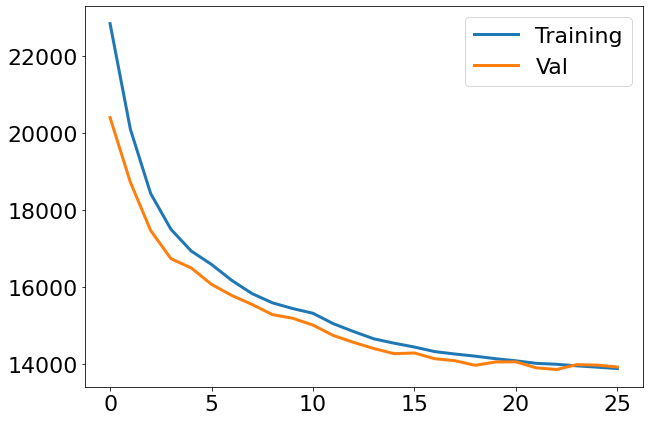

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(logger.metrics['training_loss'], label='Training', lw=3)
plt.plot(logger.metrics['val_loss'], label='Val', lw=3)
plt.legend()
plt.show()

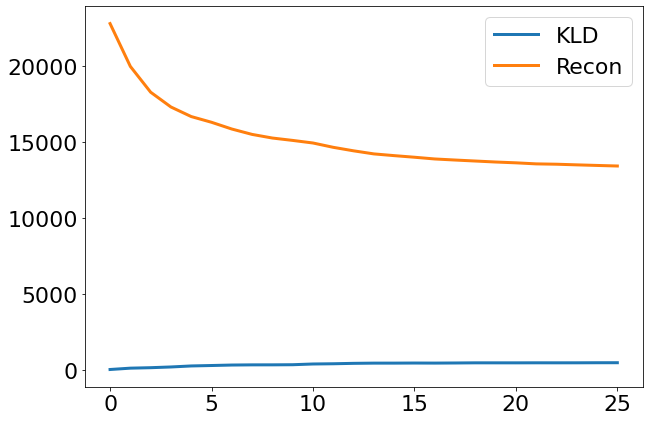

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(logger.metrics['training_kld_loss'], label='KLD', lw=3)
plt.plot(logger.metrics['training_recons_loss'], label='Recon', lw=3)
plt.legend()
plt.show()

### Q1.2 Demonstrate Reconstruction (11 pts)

In the same way as was demonstrated in Tutorial 8, the ability of your model to reconstruct the first two digits from the first batch provided by `dataloader_test`. 

Specifically, pass the first two values of `x` and `y` from `dataloader_test` to `model` and reconstruct these images. Plot them as illustrated below:

![Reconstructed MNIST digits](https://dl.sphericalcow.xyz/ecse552/W22/H3/q1.2.png)

**Note**: The batches are randomised so you won't nescessarily get the same samples shown above.

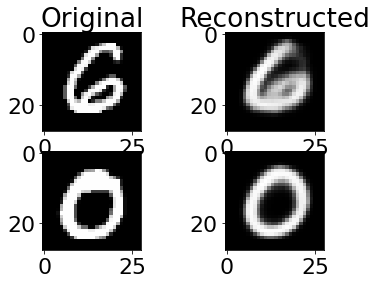

In [ ]:
for batch in dataloader_test:
  x, y = batch
  break

test_out = model(x, y)

mu, logvar, z, x_hat = test_out

fig, ax = plt.subplots(2,2)
ax[0, 0].set_title('Original')
ax[0, 0].imshow(x[0].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')
ax[0, 1].set_title('Reconstructed')
ax[0, 1].imshow(x_hat[0].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')

ax[1, 0].imshow(x[5].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')
ax[1, 1].imshow(x_hat[5].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')


### Q1.3 Demonstrate Conditional Reconstruction (13 pts)

Similar to Q1.2, reconstruct digits, but instead of using the correct $c$ vector, change the class label to a different one.

For example, the value of `y` for the two samples below are 3 and 6, but when reconstructing, the $c$ vector `[0,0,1,0,0,0,0,0,0,0]` was supplied.

![Conditioned Reconstruction](https://dl.sphericalcow.xyz/ecse552/W22/H3/q1.3.png)

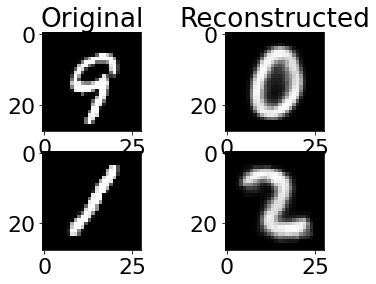

In [11]:
# Q1.3
for batch in dataloader_test:
  x, y = batch
  break

test_out = model(x, (y+1)%10)

mu, logvar, z, x_hat = test_out

fig, ax = plt.subplots(2,2)
ax[0, 0].set_title('Original')
ax[0, 0].imshow(x[0].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')
ax[0, 1].set_title('Reconstructed')
ax[0, 1].imshow(x_hat[0].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')

ax[1, 0].imshow(x[5].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')
ax[1, 1].imshow(x_hat[5].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')

### Q1.4 Explore the Latent Space (26 pts)

We now wish to traverse the latent space by individually sweeping each latent variable within a standard deviation. By doing so with a fixed value of $c$, we can better understand what individual latent variables encode for with regard to a specific digit.

Specifically, your task is to:

1. Calculate the mean ($\mu$) of latent vectors `z` from one batch provided by `dataloader_test`
2. Calculate the stdev ($\sigma$) of latent vectors `z` from one batch provided by `dataloader_test`
3. For each combination of $i \in [1\dots n]$ and $j \in [1\dots10]$:
    1. Create a [clone](https://pytorch.org/docs/stable/generated/torch.Tensor.clone.html#torch.Tensor.clone) of the $\mu$ vector named $z^{*(i,j)}$
    2. Calculate $\delta = \frac{(\mu+2\sigma) - (\mu - 2\sigma)}{9}$
    3. Make the $i$th element of $z^{*(i,j)}$ equal to $\mu_i-2\sigma_i + \delta_i \times j$ 
    4. Input into our model's decoder the latent vector $z^{*(i,j)}$ 
  and a $c$ vector that encodes for the number 2 to create an image $\hat{x}^{*(i,j)}$
4. Plot every $\hat{x}^{*(i,j)}$ in a $10\times10$ grid, where each row is a different value of $i$, and each column is a different value of $j$

Recall, $n$ is the number of latent variables.

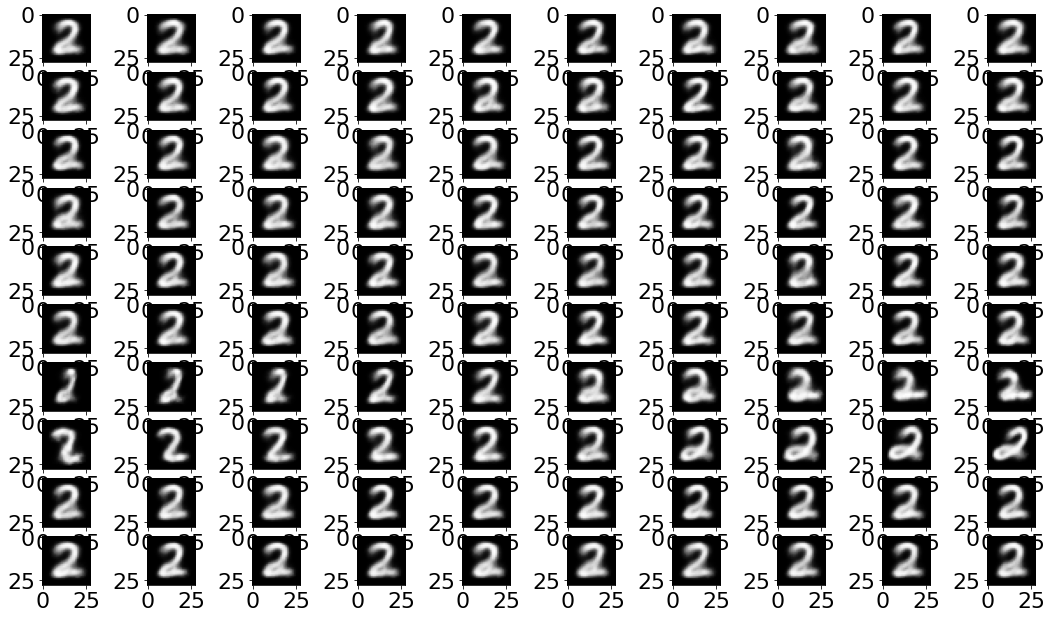

In [22]:
for batch in dataloader_test:
  x, y = batch
  break

test_out = model(x, y)

mu, logvar, z, x_hat = test_out

mu, std = torch.mean(z, dim=0).detach().numpy(), torch.std(z, dim=0).detach().numpy()

c = torch.zeros(10)
c[2] = 1.0

mu = torch.mean(z, dim=0).detach().numpy()
std = torch.std(z, dim=0).detach().numpy()

delta = ((mu + 2*std) - (mu - 2*std))/9

fig, ax = plt.subplots(10, 10)
fig.set_size_inches(18.5, 10.5)

for i in range(0, 10):
    z_ij = mu.copy()
    for j in range(0, 10):
        z_ij[i] = mu[i] - 2*std[i] + delta[i]*j
        z_c = torch.cat((torch.Tensor(z_ij), c), 0)
        x_ij = model.decoder(z_c)
        ax[i, j].imshow(x_ij.reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')


## Part 2: Graph Convolution Networks (GCN)

The node update equation for a Graph Convolution layer is given by

\begin{align}
h_u^{(l+1)} = σ(b^l + ∑_{v \in N(u)}\frac{1}{c_{u,v}} W^{(l)}h^{(l)}), 
\end{align}

where $u$ is the node, $l$ is the layer, $b$ is the bias, and $W$ is the trainable parameter matrix. Here, $h^{(0)}$ is the node feature.

A 2D Convolution layer without kernel flipping is given by

\begin{align}
S^{(l+1)}(i, j) &= σ((S^{(l)}*K^{(l)})(i,j) + b^{(l)})\\
 &= σ(∑_m ∑_n S^{(l)}(i+m,j+n) K^{(l)}(i,j) + b^{(l)}),
\end{align}

where $S$ is the feature map, and $K$ is the kernel. Here $S^{(0)}=I$ (i.e. original image).

### Question 2.1: Assuming that there is no 2D pooling, under which conditions are GraphConv and 2DConv equivalent? (13 pts)
We are looking for hyperparameters, graph properties, and kernel properties. Show your reasoning. 

### Question 2.2: Assuming that there is a 2D pooling after the 2D convolution, under which conditions are GraphConv and 2DConv+2D pool equivalent? (11 pts)
We are looking for hyperparameters, graph properties, and kernel properties. Show your reasoning. 

*Hint: start by describing the graph that is equivalent to an image*